In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


In [3]:
from pandasgui import show

In [4]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
column_names = [
    "MPG",
    "Cylinders",
    "Displacement",
    "Horsepower",
    "Weight",
    "Acceleration",
    "Model Year",
    "Origin",
]

raw_dataset = pd.read_csv(
    url,
    names=column_names,
                                              na_values='?', comment='\t',
    sep=" ",
    skipinitialspace=True,
)

In [5]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
dataset = dataset.dropna()

In [8]:
dataset["Origin"] = dataset["Origin"].map({1: "USA", 2: "Europe", 3: "Japan"})
dataset = pd.get_dummies(dataset, columns=["Origin"], prefix="", prefix_sep="")
dataset.tail

<bound method NDFrame.tail of       MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
0    18.0          8         307.0       130.0  3504.0          12.0   
1    15.0          8         350.0       165.0  3693.0          11.5   
2    18.0          8         318.0       150.0  3436.0          11.0   
3    16.0          8         304.0       150.0  3433.0          12.0   
4    17.0          8         302.0       140.0  3449.0          10.5   
..    ...        ...           ...         ...     ...           ...   
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Europe  Japan  USA  
0            70       0      0    1  
1            70       0      

In [9]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


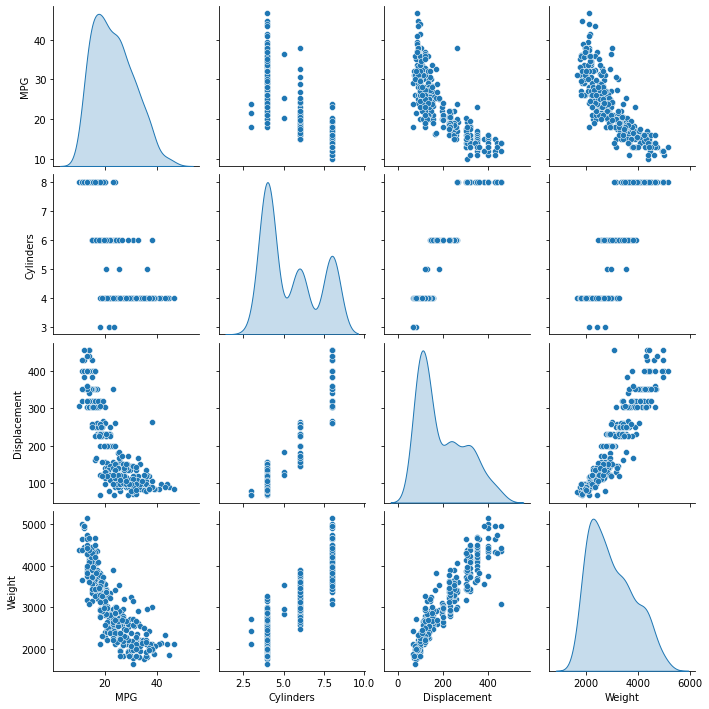

In [10]:
sns.pairplot(
    train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde"
)
train_dataset.describe().transpose()

In [11]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop("MPG")
test_labels = test_features.pop("MPG")

In [12]:
train_dataset.describe().transpose()[["mean", "std"]]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [13]:
normalizer = preprocessing.Normalization()

In [14]:
normalizer.adapt(np.array(train_features))

In [15]:
print(normalizer.mean.numpy())

[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
    0.624]


In [16]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print("First Example:", first)
    print()
    print("Normalized:", normalizer(first).numpy())

First Example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


In [17]:
horsepower = np.array(train_features["Horsepower"])

horsepower_normalizer = preprocessing.Normalization(
    input_shape=[
        1,
    ]
)
horsepower_normalizer.adapt(horsepower)

In [18]:
hp_model = tf.keras.Sequential([horsepower_normalizer, layers.Dense(units=1)])

hp_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [19]:
hp_model.predict(horsepower[:10])

array([[-0.555],
       [-0.313],
       [ 1.024],
       [-0.778],
       [-0.703],
       [-0.276],
       [-0.834],
       [-0.703],
       [-0.183],
       [-0.313]], dtype=float32)

In [20]:
hp_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1), loss="mean_absolute_error"
)

In [21]:
%%time
history = hp_model.fit(
    train_features["Horsepower"],
    train_labels,
    epochs=100,
    verbose=0,
    validation_split=0.2,
)

Wall time: 7.81 s


In [22]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.802891,4.190629,95
96,3.803769,4.173037,96
97,3.803536,4.186506,97
98,3.806424,4.210414,98
99,3.805856,4.185671,99


In [23]:
def plot_loss(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.ylim([0, 10])
    plt.xlabel("Epoch")
    plt.ylabel("Error [MPG]")
    plt.legend()
    plt.grid = True

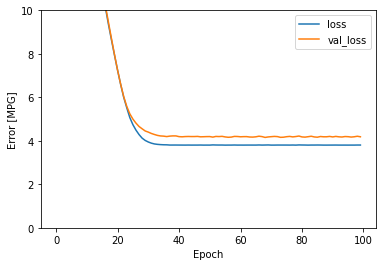

In [24]:
plot_loss(history)

In [25]:
test_results = {}

test_results["hp_model"] = hp_model.evaluate(
    test_features["Horsepower"], test_labels, verbose=0
)

In [26]:
x = tf.linspace(0.0, 250, 251)
y = hp_model.predict(x)

In [27]:
def plot_hp(x, y):
    plt.scatter(train_features["Horsepower"], train_labels, label="Data")
    plt.plot(x, y, color="k", label="Predictions")
    plt.xlabel("Horsepower")
    plt.ylabel("MPG")
    plt.legend()

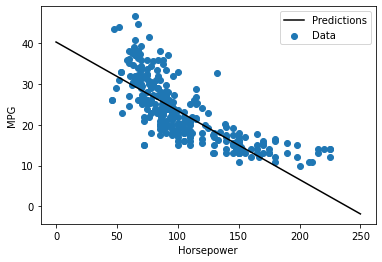

In [28]:
plot_hp(x, y)

In [29]:
linear_model = tf.keras.Sequential([normalizer, layers.Dense(units=1)])

In [30]:
linear_model.predict(train_features[:10])

array([[-0.377],
       [-0.178],
       [-0.09 ],
       [-1.04 ],
       [-0.163],
       [-0.395],
       [-0.143],
       [ 1.56 ],
       [-0.21 ],
       [ 0.663]], dtype=float32)

In [31]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.447],
       [ 0.22 ],
       [ 0.222],
       [ 0.092],
       [ 0.337],
       [-0.298],
       [-0.088],
       [-0.505],
       [-0.762]], dtype=float32)>

In [32]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1), loss="mean_absolute_error"
)

In [33]:
%%time
history = linear_model.fit(
    train_features, train_labels, epochs=100, verbose=0, validation_split=0.2
)

Wall time: 6.84 s


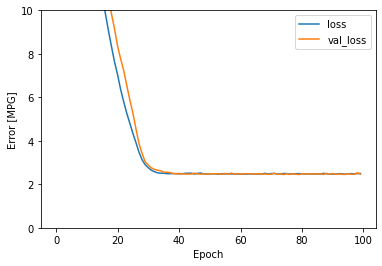

In [34]:
plot_loss(history)

In [35]:
test_results["linear_model"] = linear_model.evaluate(
    test_features, test_labels, verbose=0
)

In [36]:
def build_and_compile_model(norm):
    model = keras.Sequential(
        [
            norm,
            layers.Dense(64, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(1),
        ]
    )
    model.compile(loss="mean_absolute_error", optimizer=tf.keras.optimizers.Adam(0.001))

    return model

In [37]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [38]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [39]:
%%time
history = dnn_horsepower_model.fit(
    train_features["Horsepower"],
    train_labels,
    validation_split=0.2,
    epochs=100,
    verbose=0,

)

Wall time: 7.33 s


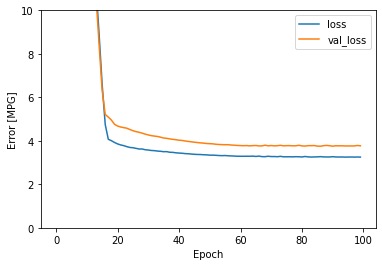

In [40]:
plot_loss(history)

In [41]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

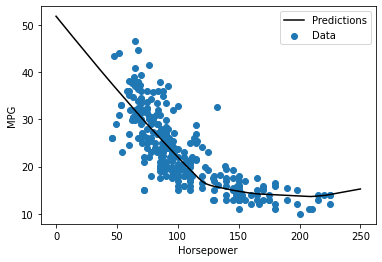

In [43]:
plot_hp(x,y)

In [45]:
test_results["dnn_horsepower_model"] = dnn_horsepower_model.evaluate(
    test_features["Horsepower"], test_labels, verbose=0
)

In [46]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 9)                 19        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [47]:
%%time
history = dnn_model.fit(
train_features, train_labels, 
validation_split=0.2, verbose=0, epochs=100)

Wall time: 7.1 s


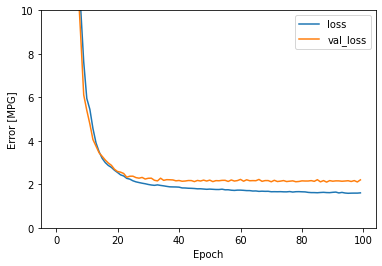

In [48]:
plot_loss(history)

In [49]:
test_results["dnn_model"] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [50]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
hp_model,3.633282
linear_model,2.496806
dnn_horsepower_model,2.908225
dnn_model,1.603869


In [69]:
test_predictions = dnn_model.predict(test_features).flatten()
# show(test_dataset)
print(test_predictions[:10])
print(test_labels[:10])

# a = plt.axes(aspect='equal')
# plt.scatter(test_labels, test_predictions)
# plt.xlabel('True Values [MPG]')
# plt.ylabel('Predictions [MPG]')
# lims = [0,50]
# plt.xlim(lims)
# plt.ylim(lims)
# _ = plt.plot(lims, lims)

[15.848 10.919 10.928 24.969 21.101 13.018 13.233 12.637 18.996 31.308]
9     15.0
25    10.0
28     9.0
31    25.0
33    19.0
39    14.0
40    14.0
43    13.0
48    18.0
54    35.0
Name: MPG, dtype: float64


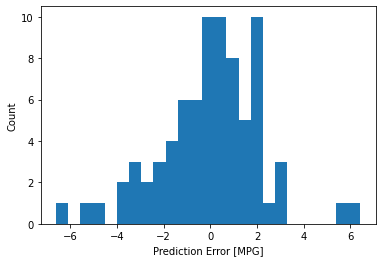

In [56]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel("Count")